In [1]:
import sys
import os
cwd = os.path.dirname(os.getcwd())
sys.path.append(cwd)
import numpy as np
import tushare as ts
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import analyst as al
import assistant as at
import messenger as ms
import datetime
import trader as tr
import random
%matplotlib inline
sns.set()

C:\Users\Xiao\Miniconda3\envs\athena\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
# 买盘与卖盘比例
def buy_rate(df):
    result = df['type'].value_counts()['买盘'] / len(df)
    return result

# 根据条件筛选DF
def _subset(df, cls='volume', percent=0.05, top=True):
    if top == True:
        sig = df[cls].quantile(1-percent)
        df = df.loc[df[cls]>sig, :]
    if top == False:
        sig = df[cls].quantile(percent)
        df = df.loc[df[cls]<sig, :]
    return df

# 集中度
def central_tendency(df, cls='volume', percent=0.05):
    sub = _subset(df, cls, percent)
    result = sub[cls].sum() / df[cls].sum()
    return result

# 资金流向
def net_flow(df):
    in_amount = df.loc[df['type']=='买盘', :]['amount'].sum()
    out_amount = df.loc[df['type']=='卖盘', :]['amount'].sum()
    net_amount = in_amount - out_amount
    return net_amount

# 价格变化
def act_price_change(df):
    price_list = df['price'].tolist()
    price_change = price_list[0] - price_list[-1]
    return price_change

# 资金导致的价格变动
def theo_price_change(df):
    result = net_flow(df) / df['volume'].sum() / 100
    return result

# 资金振幅
def max_price_change(df):
    price_list = df['price'].tolist()
    result = max(price_list) - min(price_list)
    return result

# 获的characteristics
def get_characteristics(df, top_percent=0.05, bottom_percent=0.5, cls='volume'):
    dic = {}
    dic['act_price_change'] = act_price_change(df)
    dic['theo_price_change'] = theo_price_change(df)
    dic['resistence'] = dic['theo_price_change'] - dic['act_price_change']
    dic['buy_rate'] = buy_rate(df)
    dic['central_tendency'] = central_tendency(df, cls, top_percent)
    dic['net_flow'] = net_flow(df)
    dic['open'] = df['price'].tolist()[len(df) - 1]
    dic['close'] = df['price'].tolist()[0]
    dic['high'] = max(df['price'].tolist())
    dic['low'] = min(df['price'].tolist())
    
    df_top = _subset(df, cls, top_percent)
    dic['top_buy_rate'] = buy_rate(df_top)
    dic['top_net_flow'] = net_flow(df_top)
    
    df_bottom = _subset(df, cls, bottom_percent, False)
    dic['bottom_buy_rate'] = buy_rate(df_bottom)
    dic['bottom_net_flow'] = net_flow(df_bottom)
    
    return dic

def get_dataframe(code, start_date='', duration=30, top_percent=0.05, bottom_percent=0.5, cls='volume', multi_threads=20):
    days_list = at.opening_days(days=duration, start_date=start_date, multi_threads=multi_threads)
    lis = []
    for i in days_list:
        try:
            dicc = {}
            dicc['date'] = i
            dicc['code'] = code
            df = ms.get_tick_data(code, i)
            dic = get_characteristics(df, top_percent, bottom_percent, cls)
            dic.update(dicc)
            lis.append(dic)
        except:
            pass
    frame = pd.DataFrame(lis)
    frame = frame[[
        'code', 'date', 'open', 'close', 'high', 'low', 'act_price_change', 'theo_price_change', 'resistence', 'buy_rate', 
        'central_tendency', 'net_flow', 'top_buy_rate', 'top_net_flow', 'bottom_buy_rate', 'bottom_net_flow'
    ]]
    return frame

def to_same_scale(val, lis):
    mean_val = np.mean(lis)
    min_val = min(lis)
    max_val = max(lis)
    result = (val - mean_val) / (max_val - min_val)
    return result

# 把DF分成若干等份
def split_frame(df, length):
    df_list = []
    for i in range(0, len(df)-length):
        df_list.append(df.loc[i: i+length, :])
    return df_list

# 计算特征得分
def get_score(df, col, thread=0):
    score = len(df[df[col]>thread]) / len(df)
    return score

# 提取特征函数
def get_features(df):
    dic = {}
    dic['emotion'] = get_score(df, 'smoothed difference')
    dic['cash'] = get_score(df, 'smoothed actual')
    dic['close'] = np.average(df['close'])
    dic['volume'] = np.max(df['volume'])
    return dic

In [3]:
# 获取最终特征DF
def get_prepared(df, up_thread=0.02, days_after=5):
    dfc = pd.DataFrame.copy(df)
    dfc['net_flow'] = dfc['net_flow'].apply(lambda x: to_same_scale(x, dfc['net_flow'].tolist()))
    dfc['top_net_flow'] = dfc['top_net_flow'].apply(lambda x: to_same_scale(x, dfc['net_flow'].tolist()))
    dfc['bottom_net_flow'] = dfc['bottom_net_flow'].apply(lambda x: to_same_scale(x, dfc['bottom_net_flow'].tolist()))
    dfc['resistence'] = dfc['resistence'].apply(lambda x: to_same_scale(x, dfc['resistence'].tolist()))
    
    dfc_list = split_frame(dfc, days_after)
    up_thread = up_thread
    feature_list = []
    for i in dfc_list:
        _dict = {}
        _dict['code'] = i['code'].tolist()[-1]
        _dict['date'] = i['date'].tolist()[-1]
        # close_list = i['close'].tolist()
        # _dict['close'] = close_list[-1]
        # _dict['up'] = int(((close_list[-1] - close_list[0]) / close_list[0]) > up_thread)
        _dict['up'] = int(((max(i['high'].tolist()) - i['close'].tolist()[0]) / i['close'].tolist()[0]) > up_thread)
        _dict['resistence'] = get_score(i, 'resistence')
        _dict['buy_rate'] = get_score(i, 'buy_rate', 0.5)
        _dict['central_tendency'] = get_score(i, 'central_tendency', 0.4)
        _dict['net_flow'] = get_score(i, 'net_flow')
        _dict['top_buy_rate'] = get_score(i, 'top_buy_rate', 0.5)
        _dict['top_net_flow'] = get_score(i, 'top_net_flow')
        _dict['bottom_buy_rate'] = get_score(i, 'bottom_buy_rate', 0.5)
        _dict['bottom_net_flow'] = get_score(i, 'bottom_net_flow')
        feature_list.append(_dict)
        
    return pd.DataFrame(feature_list)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc
import itertools

# model selection函数
def model_performance(clf, df, x_col, y_col, folds=5):
    x_set = df.loc[ :, x_col]
    y_set = df.loc[ :, y_col]
    
    # 构建所有可能的组合
    combinations = []
    for i in range(1, len(x_col)+1):
        combinations += (list(itertools.combinations(x_col, i)))
    
    y_set = df.loc[ :, y_col]
    selection_results = []
    
    for j in combinations:

        x_set = df.loc[ :, j]

        dic = {}

        # 获取选用的attribute
        for k in x_col:
            if k in j:
                dic[k] = 1
            else:
                dic[k] = 0

        dic['parameters'] = len(j)

        # average cross validation score
        dic['cross_val_score'] = np.mean(cross_val_score(clf, x_set, y_set, cv=folds))

        # confusion matrix with cross validation
        y_pred = cross_val_predict(clf, x_set, y_set, cv=folds)
        tn, fp, fn, tp = confusion_matrix(y_set, y_pred).ravel() / len(y_pred) #如果需要加入confusion matrix，dic['confusion_matrix'] = confusion_matrix(y_set, y_pred)
        dic['true negative'] = tn
        dic['false positive'] = fp
        dic['false negative'] = fn
        dic['true positive'] = tp

        # roc-auc with cross validation
        cv = StratifiedKFold(n_splits=folds)
        auc_scores = []
        for train, test in cv.split(x_set, y_set): # 此处train, test只是索引
            probas_ = clf.fit(x_set.iloc[train], y_set.iloc[train]).predict_proba(x_set.iloc[test])
            fpr, tpr, thresholds = roc_curve(y_set.iloc[test], probas_[:, 1])
            roc_auc = auc(fpr, tpr) # 如果需要使用roc_auc_score函数，roc_auc_score(y_set.iloc[test], probas_[:, 1])
            auc_scores.append(roc_auc)
        dic['auc_score_mean'] = np.mean(auc_scores)
        dic['auc_score_std'] = np.std(auc_scores)

        selection_results.append(dic)

    result = pd.DataFrame(selection_results)[[
        'parameters', 'cross_val_score', 'auc_score_mean', 'auc_score_std',
        'true negative', 'true positive', 'false negative', 'false positive'
    ] + x_col]
    
    return result

In [5]:
df =  get_dataframe('601318', '2017-11-21', 300)

In [6]:
feature_df = get_prepared(df, up_thread=0.02, days_after=5)

In [7]:
clf = LogisticRegression()
x_col = ['resistence', 'buy_rate', 'central_tendency', 'net_flow', 'top_buy_rate', 'top_net_flow', 'bottom_buy_rate', 'bottom_net_flow']
y_col = 'up'
result = model_performance(clf, feature_df, x_col, y_col, 5)

In [8]:
# result.to_excel('result.xlsx')

In [9]:
from sklearn.model_selection import train_test_split
clf = LogisticRegression()
# x_col = ['top_net_flow', 'net_flow', 'top_buy_rate', 'bottom_net_flow']
feature_df['intercept'] = 1
# x_col = ['central_tendency', 'top_buy_rate', 'intercept']
x_col = ['intercept', 'resistence', 'buy_rate', 'central_tendency', 'net_flow', 'top_buy_rate', 'top_net_flow', 'bottom_buy_rate', 'bottom_net_flow']
y_col = 'up'
x_train = feature_df.loc[ :100, x_col]
y_train = feature_df.loc[ :100, y_col]
x_test = feature_df.loc[100:, x_col]

clf.fit(x_train, y_train)
signal_list = clf.predict(x_test)

In [10]:
feature_df.loc[100:, ['date']]['signal'] = signal_list

In [18]:
dffz = feature_df.loc[100:, ['date']]
dffz['signal'] = signal_list

ValueError: Length of values does not match length of index

In [12]:
dffc = df[['code', 'date', 'open', 'close', 'high', 'low']]

In [13]:
dffy = dffc.merge(dffz, on='date', how='left').loc[105: ,].reset_index().drop('index', axis=1)

In [14]:
# 构建action_list
state = 0
hold = 0
action_list = []
for index, row in dffy.iterrows():
    if hold == 0 and state == 1:
        action_list.append({'date': row['date'], 'action': 'buy', 'price': row['open']})
        hold = 1
    elif hold == 1 and state == 0:
        action_list.append({'date': row['date'], 'action': 'sell', 'price': row['open']})
        hold = 0
    else: pass
    if row['signal'] == 1 and state == 0:
        state = 1
    if row['signal'] == 0 and state == 1:
        state = 0

In [15]:
s = tr.StockAccount(time=action_list[0]['date'])
s.deposit(date=action_list[0]['date'], quantity=100000)
for i in action_list:
    if i['action'] == 'buy':
        s.buy(code='601318', date=i['date'], price=i['price'], quantity=1, in_graph=True)
    elif i['action'] == 'sell':
        s.sell(code='601318', date=i['date'], price=i['price'], quantity=1)

<urlopen error timed out>
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||  100%


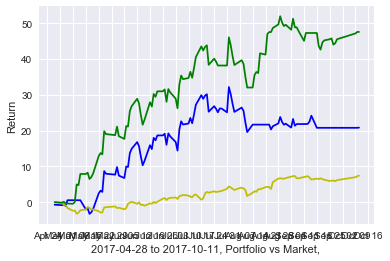

In [16]:
s.plot_performance_with_index()